# GAN Debugging Notebook

This notebook is provided to help you debug your code. We provide you with small discriminator and generator networks that you can train on the MNIST dataset. This small GAN can be trained quickly on MNIST and will help you verify that your loss functions and training code is correct.

In [1]:
!which python
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

/Users/harddrive/opt/anaconda3/bin/python


In [2]:
from gan.train import train
from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img
from gan.losses import discriminator_loss, generator_loss, ls_discriminator_loss, ls_generator_loss

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## MNIST Dataset


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw




Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw
Processing...


/Users/harddrive/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1603740477510/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


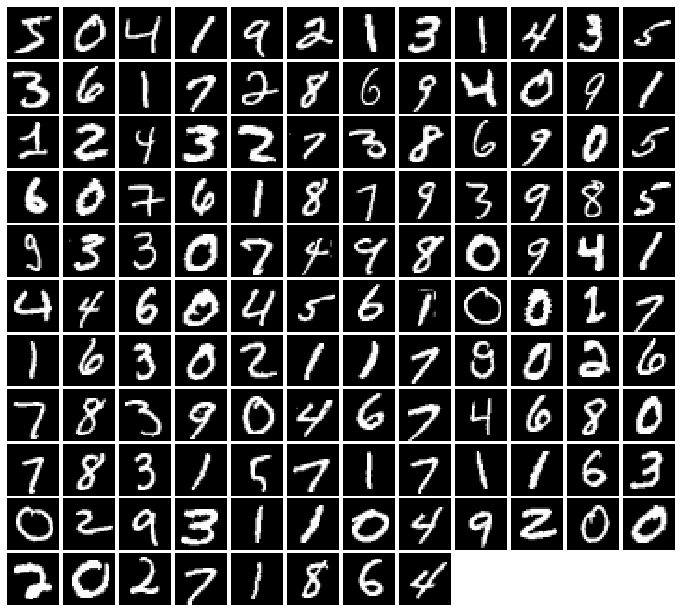

In [4]:
NOISE_DIM = 100
batch_size = 128

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

# Discriminator and Generator


In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image


In [6]:
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential( Flatten(),
                                torch.nn.Linear(784, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 1)
    )
    return model

In [7]:
def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    
    model = nn.Sequential(
        torch.nn.Linear(noise_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 784),
        torch.nn.Tanh()
    )

    return model

Test to make sure the number of parameters in the generator is correct:

# Train

The simple model provided will train on MNIST in only a few minutes. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="files/gan_samples/mnist.jpg" width=500>

EPOCH:  1
Iter: 0, D: 0.01049, G:0.005545


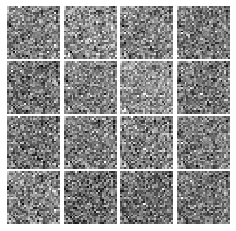


Iter: 250, D: 0.007672, G:0.01235


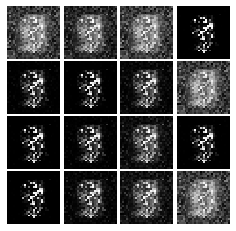


EPOCH:  2
Iter: 500, D: 0.008741, G:0.007675


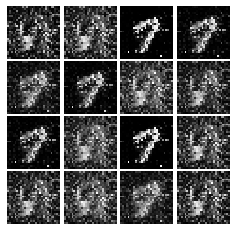


Iter: 750, D: 0.009608, G:0.02017


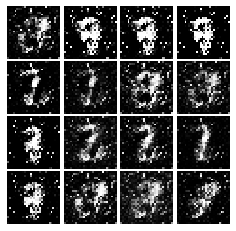


EPOCH:  3
Iter: 1000, D: 0.007415, G:0.01197


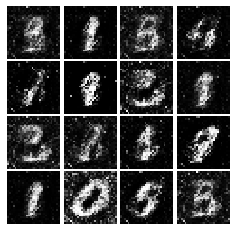


Iter: 1250, D: 0.009732, G:0.008728


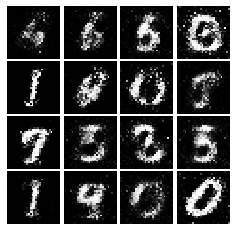


EPOCH:  4
Iter: 1500, D: 0.008827, G:0.00663


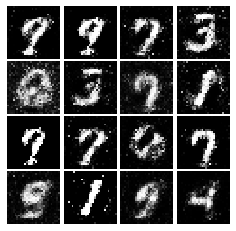


Iter: 1750, D: 0.008197, G:0.009219


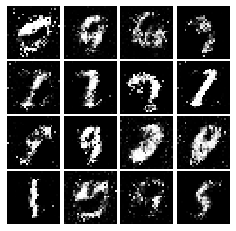


EPOCH:  5
Iter: 2000, D: 0.009129, G:0.007525


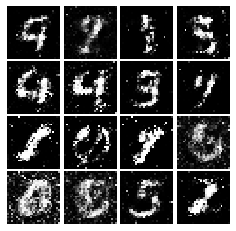


Iter: 2250, D: 0.009754, G:0.00813


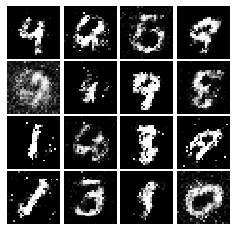


EPOCH:  6
Iter: 2500, D: 0.009358, G:0.008966


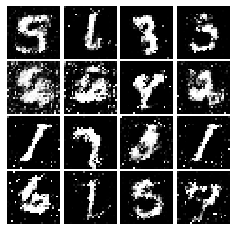


Iter: 2750, D: 0.009261, G:0.007187


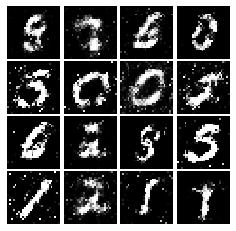


EPOCH:  7
Iter: 3000, D: 0.00982, G:0.007742


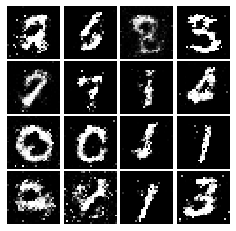


Iter: 3250, D: 0.008775, G:0.006899


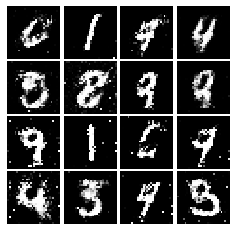


EPOCH:  8
Iter: 3500, D: 0.01009, G:0.00719


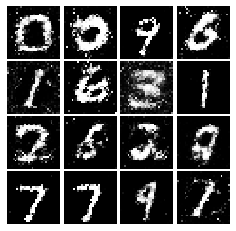


EPOCH:  9
Iter: 3750, D: 0.009664, G:0.006893


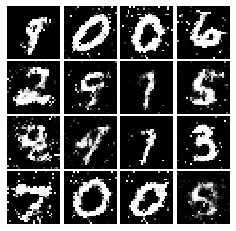


Iter: 4000, D: 0.01069, G:0.007331


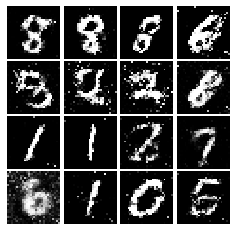


EPOCH:  10
Iter: 4250, D: 0.009678, G:0.007646


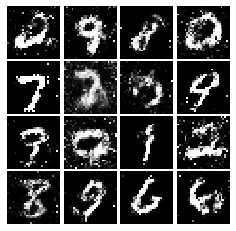


Iter: 4500, D: 0.009766, G:0.006057


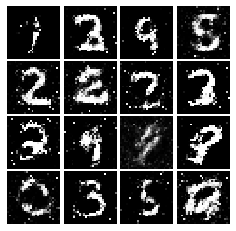

In [8]:
# original GAN
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device)

EPOCH:  1
Iter: 0, D: 0.00379, G:0.0037


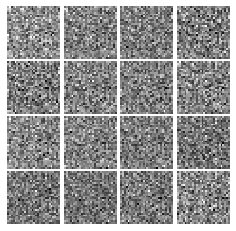


Iter: 250, D: 0.0005371, G:0.002112


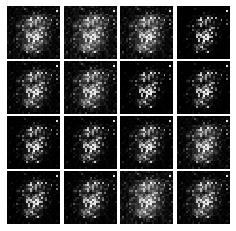


EPOCH:  2
Iter: 500, D: 0.001363, G:0.001707


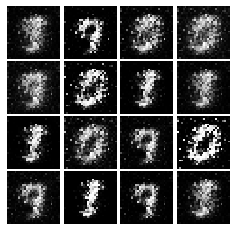


Iter: 750, D: 0.0008728, G:0.004947


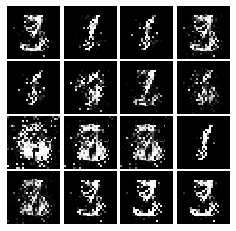


EPOCH:  3
Iter: 1000, D: 0.001326, G:0.001904


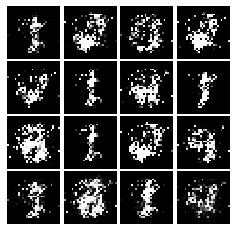


Iter: 1250, D: 0.001671, G:0.001854


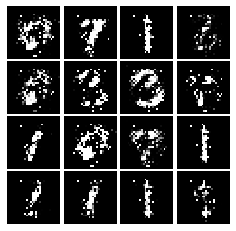


EPOCH:  4
Iter: 1500, D: 0.001124, G:0.002569


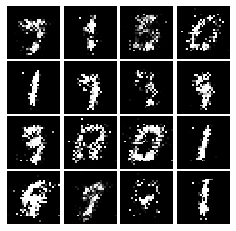


Iter: 1750, D: 0.001413, G:0.001737


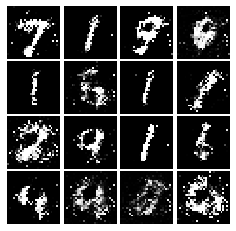


EPOCH:  5
Iter: 2000, D: 0.001461, G:0.001622


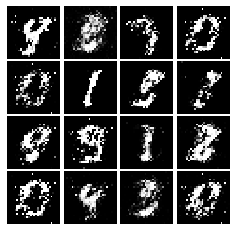


Iter: 2250, D: 0.001412, G:0.001599


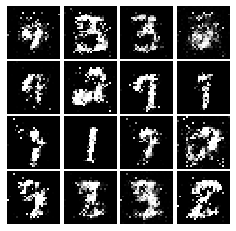


EPOCH:  6
Iter: 2500, D: 0.001587, G:0.001568


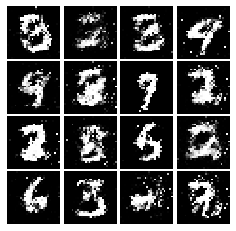


Iter: 2750, D: 0.00172, G:0.001407


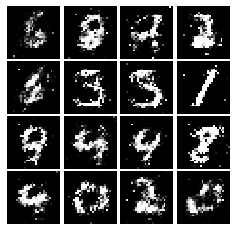


EPOCH:  7
Iter: 3000, D: 0.001733, G:0.001467


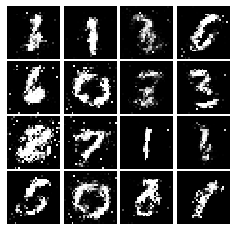


Iter: 3250, D: 0.001713, G:0.001394


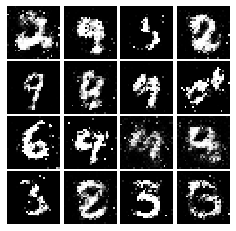


EPOCH:  8
Iter: 3500, D: 0.001713, G:0.001411


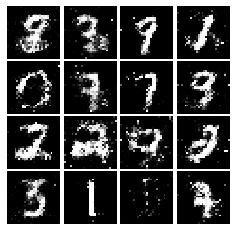


EPOCH:  9
Iter: 3750, D: 0.001676, G:0.00147


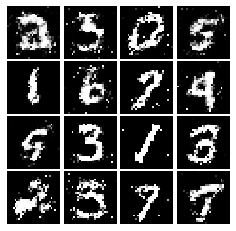


Iter: 4000, D: 0.002005, G:0.001299


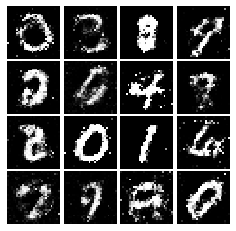


EPOCH:  10
Iter: 4250, D: 0.001907, G:0.001445


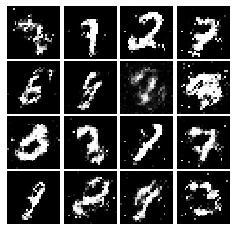


Iter: 4500, D: 0.001795, G:0.001301


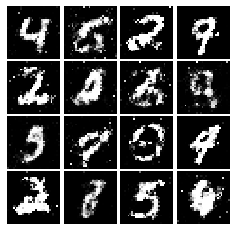

In [9]:
# LSGAN
D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_optimizer = torch.optim.Adam(D_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_LS_optimizer = torch.optim.Adam(G_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D_LS, G_LS, D_LS_optimizer, G_LS_optimizer, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device)